# Weather Station Data - cleaned final version 
## Level 1 QC

In [1]:
#import external libraries
import pandas as pd
import os
#pd.options.mode.chained_assignment =  # default='warn'; chained index warning
import numpy as np
import imp
import datetime
import pytz

#plotting
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import LVL1
import CleanWxData as wx
import settings
from settings import base_path, Glacier, Station

save_plots=False

data_columns, general_data_columns, out_date_format, precip_columns, precip_gage_change, primary_temp_column, temp_columns, timezone, wind_col, wind_dir_columns = settings.get_settings(settings.Glacier, settings.Station)

In [2]:
#Do you want to display plots (slow for large datasets)
show_plots=True #True= show plots
frac=0.1 #fraction of data to show in plots (0.3 = 30%)

In [3]:
base_path

'C:\\Users\\ehbaker\\Documents/BrokenServer/'

** Define Location-Specific Baseline Settings **

In [4]:
#path to level 0 data
file_label='_15min_all'
pth=base_path + 'Data/'+Glacier+ r"/AllYears/Wx/LVL0/" + Glacier.lower()+ Station+ file_label+'_LVL0' +".csv"
  
#time format and column
local_time_column_name='local_time'
date_format='%Y/%m/%d %H:%M'

#directory to save output data
save_pth=base_path +'Data/' +Glacier+ r"/AllYears/Wx/LVL1/" + Glacier.lower()+Station+file_label+"_LVL1.csv"

### Data import
- read in data 
- set timezone
- set time as index

In [5]:
#read in level0 CSV
if (Glacier + Station == 'Wolverine990') | (Glacier + Station =='Gulkana1480')| (Glacier+Station=='Gulkana1725') | (Glacier+Station=='Wolverine370'):
    pth=base_path +r"Data/" + Glacier + r'/AllYears/Wx/LVL0/telemetry_added/' + Glacier.lower() + Station+ file_label + '_LVL0.csv'

In [6]:
dat=pd.read_csv(pth)
print("read data from: "+ pth)

read data from: C:\Users\ehbaker\Documents/BrokenServer/Data/Gulkana/AllYears/Wx/LVL0/telemetry_added/gulkana1480_15min_all_LVL0.csv


In [7]:
dat.tail()

,local_time,UTC_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,TPGCumulative,StageCumulative,WindSpeed,WindDir,VecAvgWindDir,RelHum,WindGustSpeed
1134350,2020/08/22 13:15,2020/08/22 21:15,10.2,NaN,10.1,10.1,0.488,NaN,2.9,NaN,279.0,NaN,4.4
1134351,2020/08/22 13:30,2020/08/22 21:30,10.4,NaN,10.4,10.6,0.488,NaN,2.1,NaN,279.0,NaN,4.6
1134352,2020/08/22 13:45,2020/08/22 21:45,11.4,NaN,10.6,10.9,0.488,NaN,2.6,NaN,279.0,NaN,5.1
1134353,2020/08/22 14:00,2020/08/22 22:00,11.5,NaN,11.3,11.6,0.488,NaN,2.3,NaN,279.0,NaN,5.9
1134354,2020/08/22 14:15,2020/08/22 22:15,11.7,NaN,11.7,11.9,0.479,NaN,5.1,NaN,279.0,NaN,9.1


In [8]:
#Set local time to dataframe index
dat['local_time']=pd.to_datetime(dat[local_time_column_name], format=date_format)
dat=dat.set_index('local_time')
#dat=dat.tz_localize(timezone, ambiguous='infer')

In [9]:
#Determine if dataset contains precip data (may want to revisit this later)
precip_present=len(precip_columns)>0
temp_present=len(temp_columns)>0
wind_present=len(wind_col)>0

In [10]:
dat=dat.sort_index() #ensure data is sorted by time

In [11]:
dat.tail(10)

,UTC_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,TPGCumulative,StageCumulative,WindSpeed,WindDir,VecAvgWindDir,RelHum,WindGustSpeed
local_time,,,,,,,,,,,,
2020-08-22 12:00:00,2020/08/22 20:00,10.4,NaN,10.4,10.5,0.488,NaN,4.2,NaN,271.0,NaN,6.5
2020-08-22 12:15:00,2020/08/22 20:15,10.3,NaN,10.5,10.5,0.488,NaN,3.8,NaN,279.0,NaN,6.1
2020-08-22 12:30:00,2020/08/22 20:30,10.5,NaN,10.4,10.6,0.488,NaN,2.2,NaN,279.0,NaN,4.6
2020-08-22 12:45:00,2020/08/22 20:45,10.1,NaN,10.4,10.1,0.488,NaN,1.9,NaN,279.0,NaN,4.2
2020-08-22 13:00:00,2020/08/22 21:00,10.4,NaN,10.2,10.4,0.488,NaN,2.8,NaN,279.0,NaN,3.8
2020-08-22 13:15:00,2020/08/22 21:15,10.2,NaN,10.1,10.1,0.488,NaN,2.9,NaN,279.0,NaN,4.4
2020-08-22 13:30:00,2020/08/22 21:30,10.4,NaN,10.4,10.6,0.488,NaN,2.1,NaN,279.0,NaN,4.6
2020-08-22 13:45:00,2020/08/22 21:45,11.4,NaN,10.6,10.9,0.488,NaN,2.6,NaN,279.0,NaN,5.1
2020-08-22 14:00:00,2020/08/22 22:00,11.5,NaN,11.3,11.6,0.488,NaN,2.3,NaN,279.0,NaN,5.9


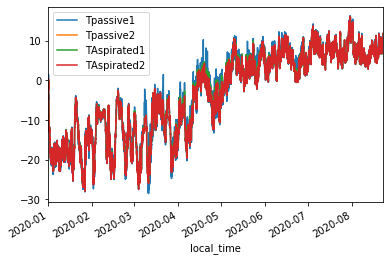

In [12]:
dat[temp_columns]['2020'].plot()

In [13]:
if save_plots:
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    dat.plot(ax=ax, subplots=True, sharex=True) # ax=ax points df.plot to fig
    for each in fig.axes: # You can still modify these axes!
        each.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data/'+ Glacier+r'\AllYears\Wx\LVL0/' +'LVL0' +Glacier +Station +'WxData.jpg')

In [14]:
#Make 2019 figure
if save_plots and dat.index[-1].year>=2018:
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    dat['2019'].plot(ax=ax, subplots=True, sharex=True) # ax=ax points df.plot to fig
    for each in fig.axes: # You can still modify these axes!
        each.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data/'+ Glacier+r'\AllYears\Wx\LVL0/' +'LVL0' +Glacier +Station +'WxData2019.jpg')

Station-specific Data Adjustments

In [15]:
# Wolverine990 and Gulkana 1480: Prior to April 2014, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[(dat.index<'2014/04/24 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat.loc[(dat.index<'2014/04/24 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan
    
if Glacier+Station=="Gulkana1480":
    dat.loc[(dat.index<'2014/04/18 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat.loc[(dat.index<'2014/04/18 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [16]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=base_path+ r"Metadata/weather"
try:
    bad_sensor_dates_dat=pd.read_excel(os.path.join(pth_bad_sensor_dates, Glacier+"_SensorLog.xlsx"),sheet_name=Glacier+Station)
    bad_sensor_dates_dat
    
    #Make sure all QC sensor names are entered correctly
    for x in bad_sensor_dates_dat.Sensor:
        if x not in dat.columns:
            print('Sensor '+ x + ' not in columns')
except:
    print("no manual QC log exists for this site")
    bad_sensor_dates_dat=pd.DataFrame()
    

In [17]:
dat.TPGCumulative

local_time
1995-08-15 06:30:00      NaN
1995-08-15 06:45:00      NaN
1995-08-15 07:00:00      NaN
1995-08-15 07:15:00      NaN
1995-08-15 07:30:00      NaN
                       ...  
2020-08-22 13:15:00    0.488
2020-08-22 13:30:00    0.488
2020-08-22 13:45:00    0.488
2020-08-22 14:00:00    0.488
2020-08-22 14:15:00    0.479
Name: TPGCumulative, Length: 1134355, dtype: float64

In [18]:
#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)
print("Removed")

2010-07-23 18:00:00 2011-07-15 17:15:00 TAspirated1
2004-02-24 00:00:00 2004-03-02 00:00:00 StageCumulative
2015-10-27 23:00:00 2016-05-26 23:00:00 TAspirated2
2016-09-22 00:00:00 2017-04-21 16:15:00 TAspirated2
2017-08-23 18:00:00 2017-08-23 18:15:00 TPGCumulative
1995-08-15 06:30:00 1995-09-30 12:00:00 StageCumulative
1995-09-30 12:00:00 2002-08-28 00:00:00 StageCumulative
2002-11-03 00:00:00 2003-05-03 00:00:00 StageCumulative
2003-11-04 00:00:00 2004-01-24 00:00:00 StageCumulative
2004-09-04 00:00:00 2005-05-09 00:00:00 StageCumulative
2004-04-24 00:00:00 2004-04-25 00:00:00 TPGCumulative
adding 0.304 to StageCumulative at 2010-07-20 20:15:00
2010-02-24 00:00:00 2010-03-03 00:00:00 Tpassive1
2010-02-24 00:00:00 2010-03-03 00:00:00 Tpassive2
2010-07-20 00:00:00 2010-07-23 00:00:00 TAspirated1
2010-07-20 00:00:00 2010-07-23 00:00:00 WindDir
2010-07-20 00:00:00 2010-07-23 00:00:00 WindGustSpeed
2010-07-20 00:00:00 2010-07-23 00:00:00 StageCumulative
2015-01-09 00:00:00 2019-04-27 00:0

In [19]:
#Save data at THIS STAGE for L0 in release
# L0_release_save_pth=base_path +'Data/' +Glacier+ r"/AllYears/Wx/LVL0_ForRelease/" + Glacier.lower()+Station+file_label+"_LVL0.csv"
# dat.reset_index()[['local_time', 'UTC_time'] +data_columns].to_csv(L0_release_save_pth, index=False, float_format='%g')

# dat.tail(1)

In [20]:
# # #Time subset for trouble-shooting
# dat=dat['2015-04':]
# for precip_col in precip_columns:
#     if pd.notnull((dat[precip_col][0])):
#         dat[precip_col]=dat[precip_col]-dat[precip_col][0]
#     else:
#         print("first val in "+ precip_col + " is null")

** Set hard-coded cutoff values** (station specific)

In [21]:
#Generic Settings
low_temp_cutoff=-40.0 #deg. C
high_temp_cutoff=30.0

obvious_error_precip_cutoff=60. #if 60 mm (6 cm) in 2 hrs, obviously an error. (7/2016 has a drain of only 24 cm)

#Glacier-specific settings; can also adjust generic settings given above here
if (Glacier+Station=="Wolverine990"):    
    Stage_dies='2015/09/01 06:30:00' #time at which instrument was removed
    TPG_born='2012/10/02 00:00:00' 

if (Glacier+Station=="Wolverine370"):   
    Stage_dies='2018/10/17 13:00:00' #this is actually the tipping bucket here; keeping name for simplicity
    TPG_born= '2018/10/18 16:00:00'   
        
if (Glacier + Station== "Gulkana1480"):    
    Stage_dies='2015/09/25 11:30:00' #time at which instrument was removed
    TPG_born='2011/07/15 18:30:00' #time at which instrument was removed
    
if (Glacier + Station== "Gulkana1725"):    
    TPG_born='2014-08-26 16:00:00'
    
if (Glacier + Station== "Wolverine1420"):    
    TPG_born='2017-07-23 13:30:00'
    
if (Glacier + Station== "Wolverine1420") | (Glacier+Station=="Gulkana1920") : #these are the 2 ridgetop JWS sites
    print('normal settings good')

In [22]:
#Convert units in precipitation columns from meters to mm
if precip_present:
    for precip_col in precip_columns:
        dat.loc[:,precip_col]=dat[precip_col]*1000

In [23]:
if precip_present:
    #Set gages to NAN, when not installed (single gauge style does not cover period of record)
    for precip_col in precip_columns:
        if dat[precip_col].isnull().all():
            print("no data in "+ precip_col)
            continue
        if 'TPG' in precip_col.upper(): #this is the current precip gage
            dat.loc[:TPG_born, precip_col]=np.nan
        if 'stage' in precip_col.lower(): #this is old precip gage
            dat.loc[Stage_dies:, precip_col]=np.nan

In [24]:
#Save unaltered data for later comparrison with edits
dat_original=dat.copy() 

** Clean Temperature Data**

In [25]:
if temp_present:
    #Temperature
    for temp_col in temp_columns:
        temps=dat.loc[:,temp_col]
        dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

C:\Users\ehbaker\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### Plot temperature data, before and after

C:\Users\ehbaker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ehbaker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


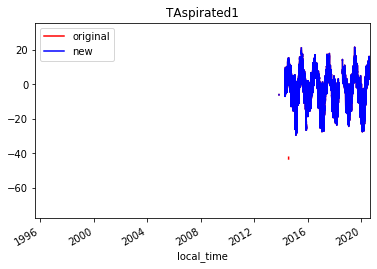

In [26]:
if show_plots:
    plt.figure()
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat, data_col_name=primary_temp_column)

** Clean Wind Speed Data **

In [27]:
#Remove wind speed data where problems with riming (or other falls to 0) are present
if wind_present:
    dat=wx.clean_wind_speed_data(dat, wind_col)

C:\Users\ehbaker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ehbaker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


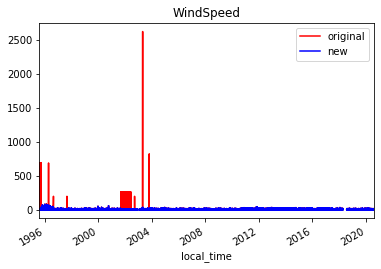

In [28]:
if show_plots and wind_present:
    plt.figure()
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat, data_col_name=wind_col)

#### Clean Wind Direction Data

In [29]:
if wind_present:
    if wind_dir_columns[0] in dat.columns:
        for col in wind_dir_columns:
            dat.loc[dat[col]>360, col]=np.nan #Nonsensical; at wolverine990, this is only 3 days; results from mis-pogramming of logger
            dat.loc[dat[col]<0, col]=np.nan 

In [30]:
#Correct direction during periods when sensor not aligned to true north
if Glacier + Station == 'Wolverine990': 
    og_dir=dat.loc['2016-09-09 11': '2017-07-23', 'VecAvgWindDir'].copy()
    adj_dir=og_dir-215 # this is 360-145, as indicated by Louis's notes
    adj_dir[adj_dir<0]=adj_dir[adj_dir<0]+360 #convert negative angles to unit circle
    dat.loc['2016-09-09 11': '2017-07-23', 'VecAvgWindDir']=adj_dir

    og_dir=dat.loc['2017-07-23': '2017-09-10', 'VecAvgWindDir'].copy()
    adj_dir=og_dir-335
    adj_dir[adj_dir<0]=adj_dir[adj_dir<0]+360 #convert negative angles to unit circle
    dat.loc['2017-07-23': '2017-09-10', 'VecAvgWindDir']=adj_dir

In [31]:
#Set times when not changing (sensor rimed or obstructed) to NAN
if wind_present:
    if wind_dir_columns[0] in dat.columns:
        for col in wind_dir_columns:
            dat[col]=wx.clean_wind_direction_data(dat, col)

C:\Users\ehbaker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ehbaker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


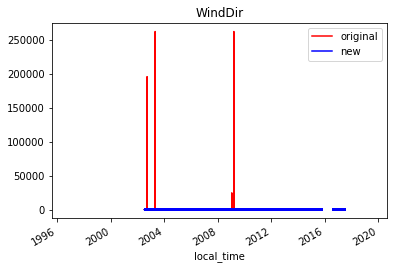

In [32]:
if show_plots and wind_present:
    plt.figure()
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat, data_col_name=wind_dir_columns[0])

** Clean RH Data **

In [33]:
if 'RelHum' in dat.columns:
    dat.loc[dat.RelHum <0, 'RelHum']=pd.np.nan
    dat.loc[dat.RelHum >100, 'RelHum']=pd.np.nan

** Clean Radiation Data **

In [34]:
for col in dat.columns:
    if 'Radiation' in col:
        print(col)
        rad_col_name=col
        dat.loc[dat[col] <0, col]=0
        dat.loc[dat[col] >1600, col]=pd.np.nan

In [35]:
if show_plots and 'rad_col_name' in locals():
    plt.figure()
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat, data_col_name=rad_col_name)

** Clean Barometeric Pressure Data **

In [36]:
if 'Barom' in dat.columns: #These limits are 50-110 kpa, from Zahumensky
    dat.loc[dat[col] <50, col]=pd.np.nan
    dat.loc[dat[col] >1110, col]=pd.np.nan

** Plot original precipitation data**

In [37]:
%matplotlib notebook

<IPython.core.display.Javascript object>


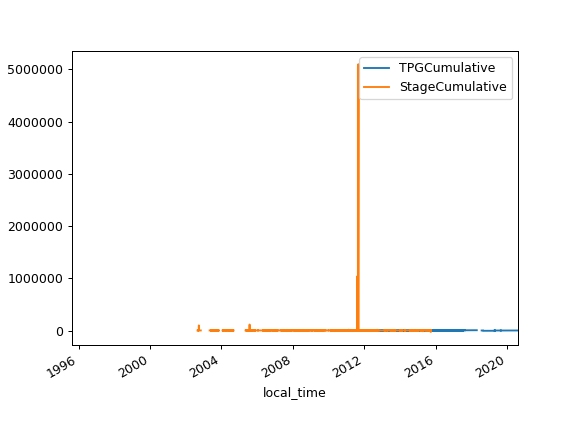

In [38]:
#Precip
if precip_present:
    dat[precip_columns].plot()

** Remove Gauge Drain and Fill Maintenance **

In [39]:
if precip_present:
    #Early stage gage measurements had HUGE thermal flctuations; on the order of 15 cm precip in a day
    if Glacier + Station=="Wolverine990":
        end_stage_extra_noise_date='2007-09-18 00'
        #Consider finding a way to folter these huge daily swings into a useful product; currently, option to NAN and trust historical data processing instead
        dat.loc[:end_stage_extra_noise_date, 'StageCumulative']=pd.np.nan #LVL1.precip_remove_drain_and_fill(dat.StageCumulative[:end_stage_extra_noise_date], obvious_error_precip_cutoff=200, n_window=4)

In [40]:
dat.tail()

,UTC_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,TPGCumulative,StageCumulative,WindSpeed,WindDir,VecAvgWindDir,RelHum,WindGustSpeed
local_time,,,,,,,,,,,,
2020-08-22 13:15:00,2020/08/22 21:15,10.2,NaN,10.1,10.1,488.0,NaN,2.9,NaN,NaN,NaN,4.4
2020-08-22 13:30:00,2020/08/22 21:30,10.4,NaN,10.4,10.6,488.0,NaN,2.1,NaN,NaN,NaN,4.6
2020-08-22 13:45:00,2020/08/22 21:45,11.4,NaN,10.6,10.9,488.0,NaN,2.6,NaN,NaN,NaN,5.1
2020-08-22 14:00:00,2020/08/22 22:00,11.5,NaN,11.3,11.6,488.0,NaN,2.3,NaN,NaN,NaN,5.9
2020-08-22 14:15:00,2020/08/22 22:15,11.7,NaN,11.7,11.9,479.0,NaN,5.1,NaN,NaN,NaN,9.1


In [41]:
def calculate_cumulative(cumulative_vals_orig, incremental_vals):
    '''
    function to calculate cumulative timeseries from two things: an input (edited) incremental series, and the original cumulative series.
    -interpolates any missing values, and re-adds those back to the timeseries at the end
    '''
    #Original values in cumulative series
    cumulative_vals=cumulative_vals_orig.copy()
    
    #store location of NANs in original timeseries
    nan_locations=cumulative_vals.isnull()
    #Calculate cumulative sum of incremental values
    new_cumulative=incremental_vals.cumsum()
    
    #Adjust so begins as same absolute value as input
    if not np.isnan(cumulative_vals[0]):
        start_value=cumulative_vals[0]
        new_cumulative = new_cumulative + start_value
        new_cumulative[0]=cumulative_vals[0] #needed, as first value of incremental series is a NAN
        
    #If data begins with NANs, must adjust based on first valid value, not first value
    else:
        start_data_index=cumulative_vals.first_valid_index()
        start_value=cumulative_vals[start_data_index]
        new_cumulative=new_cumulative+start_value
        
    #put NANs back in cumulative timeseries
    new_cumulative.loc[nan_locations]=pd.np.nan
    return(new_cumulative)   

In [51]:
precip_cumulative=dat['TPGCumulative'].copy()
n_window=4

filled=precip_cumulative.interpolate()
dPrecip=filled-filled.shift(1)
#rolling_sum=dPrecip.abs().rolling(n_window, center=True).sum()
rolling_sum=abs(dPrecip.rolling(n_window, center=True).sum())
error_center=rolling_sum>obvious_error_precip_cutoff
for xx in range(n_window*-1,n_window+1):
    #print("fixing errors at error + "+ str(xx))
    select_boolean_ser=error_center.shift(xx)
    select_boolean_ser[0:n_window]=False #set first and last xx vals to false (otherwise NAN)
    select_boolean_ser[n_window*-1:]=False
    dPrecip[select_boolean_ser]=0 #set incremental precip @ these timesteps surrounding problem to 0 as well
#new_cumulative=calculate_cumulative(precip_cumulative, dPrecip)


In [ ]:
#This is calculate cumulative function
#Original values in cumulative series
cumulative_vals_orig=precip_cumulative.copy()
cumulative_vals=cumulative_vals_orig.copy()
incremental_vals=dPrecip

#Reset index in case of duplicate times (daylight savings)
cumulative_vals=cumulative_vals.reset_index()

In [60]:
cumulative_vals

,local_time,TPGCumulative
0,1995-08-15 06:30:00,NaN
1,1995-08-15 06:45:00,NaN
2,1995-08-15 07:00:00,NaN
3,1995-08-15 07:15:00,NaN
4,1995-08-15 07:30:00,NaN
...,...,...
1134350,2020-08-22 13:15:00,488.0
1134351,2020-08-22 13:30:00,488.0
1134352,2020-08-22 13:45:00,488.0
1134353,2020-08-22 14:00:00,488.0


In [58]:
#store location of NANs in original timeseries
nan_locations=cumulative_vals.isnull()
#Calculate cumulative sum of incremental values
new_cumulative=incremental_vals.cumsum()

#Adjust so begins as same absolute value as input
if not np.isnan(cumulative_vals[0]):
    start_value=cumulative_vals[0]
    new_cumulative = new_cumulative + start_value
    new_cumulative[0]=cumulative_vals[0] #needed, as first value of incremental series is a NAN

#If data begins with NANs, must adjust based on first valid value, not first value
else:
    start_data_index=cumulative_vals.first_valid_index()
    start_value=cumulative_vals[start_data_index]
    new_cumulative=new_cumulative+start_value

KeyError: 0

In [56]:
new_cumulative.isna().all()

True

In [44]:
#put NANs back in cumulative timeseries
new_cumulative=new_cumulative.reset_index()
new_cumulative[new_cumulative.local_time.isin(nan_locations)]=pd.np.nan
new_cumulative.set_index('local_time', inplace=True)

In [47]:
new_cumulative

,StageCumulative
local_time,
1995-08-15 06:30:00,NaN
1995-08-15 06:45:00,NaN
1995-08-15 07:00:00,NaN
1995-08-15 07:15:00,NaN
1995-08-15 07:30:00,NaN
...,...
2020-08-22 13:15:00,4.123836e+06
2020-08-22 13:30:00,4.123836e+06
2020-08-22 13:45:00,4.123836e+06


In [86]:
new_cumulative.pop('index')
#return(new_cumulative)   

KeyError: 'index'

In [85]:
new_cumulative=new_cumulative.reset_index()
new_cumulative[new_cumulative.local_time.isin(nan_locations)]=pd.np.nan
new_cumulative.set_index('local_time', inplace=True)
new_cumulative.pop('index')


,TPGCumulative
local_time,
1995-08-15 06:30:00,NaN
1995-08-15 06:45:00,NaN
1995-08-15 07:00:00,NaN
1995-08-15 07:15:00,NaN
1995-08-15 07:30:00,NaN
...,...
2019-12-31 22:45:00,NaN
2019-12-31 23:00:00,NaN
2019-12-31 23:15:00,NaN


In [91]:
if precip_present:
    #Remove unrealistically large instantaneous jumps; create continuous timreseries
    for precip_col in precip_columns:
        if dat[precip_col].isnull().all():
            print("no data in "+ precip_col)
            continue    
        print(precip_col)
        if dat[precip_col].isnull().all(): #if no values in column, skip
            continue
        #dat.loc[:,precip_col]=
        dat[precip_col]=LVL1.precip_remove_drain_and_fill(dat[precip_col], obvious_error_precip_cutoff=obvious_error_precip_cutoff, n_window=4)
    dat_step0=dat[precip_columns].copy() #save for plotting

TPGCumulative


ValueError: cannot reindex from a duplicate axis

In [ ]:
if precip_present:
    #Plot
    if not dat[precip_columns[0]].isnull().all() and show_plots:
        plt.figure()
        LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[0], label_old="original", label_new="drain and fill removed")

In [ ]:
if precip_present and len(precip_columns)>1:
    #Plot stage-type precip gage
    if not dat[precip_columns[1]].isnull().all() and show_plots :
        plt.figure()
        ax=LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[1], label_old="original", label_new="drain and fill removed")
else:
    print('no secondary precip record')

In [ ]:
if precip_present:
    #Set no-data values before TPG installed, and after rocket removed to NAN (not 0)
    for precip_col in precip_columns:
        if dat[precip_col].isnull().all(): #if no values in column, skip
            continue
        if 'TPG' in precip_col.upper():
            dat.loc[:TPG_born, precip_col]=np.nan
        if 'stage' in precip_col.lower():
            dat.loc[Stage_dies:, precip_col]=np.nan

## START the L2 Precip Stuff here!!!

In [ ]:
# if precip_present:
#     #Strip high-amplitude noise related to wind with hampel filter
#     for precip_col in precip_columns:
#         if dat[precip_col].isnull().all():
#             continue
#         dat.loc[:,precip_col]=LVL1.hampel(dat_step0[precip_col], t0=2)
#     dat_step1=dat[precip_columns].copy() #save for plotting

# if precip_present:
#     #Run filter on daily window, to remove sensor malfunctions
#     for precip_col in precip_columns:
#         if dat[precip_col].isnull().all():
#             continue
#         dat.loc[:,precip_col]=LVL1.basic_median_outlier_strip(dat_step1[precip_col],k=96, threshold=10) #remove values > 10 mm (1cm)from daily median val
#     dat_step2=dat[precip_columns].copy() #save for plotting

# #Plot results
# if precip_present:
#     if show_plots and not dat_original[precip_columns[0]].isnull().all():
#         plt.figure()
#         LVL1.plot_comparrison(df_old=dat_step0, df_new=dat_step2, data_col_name=precip_columns[0], label_old="original", label_new="after hampel outlier filter")

# if precip_present and len(precip_columns)>1:
#     #Plot results
#     if show_plots and not dat_original[precip_columns[1]].isnull().all():
#         plt.figure()
#         LVL1.plot_comparrison(df_old=dat_step0, df_new=dat_step2, data_col_name=precip_columns[1], label_old="original", label_new="after hampel outlier filter")

**Smooth Data with method from Nayak (2010): **

In [ ]:
# if precip_present:
#     #Smooth Incremental Precip Data, if there are any decreases in the record
#     dx=dat[precip_col]-dat[precip_col].shift(1)
#     if dx.min()<0:
#         for precip_col in precip_columns:
#             #Smooth this data with method from Nayak 2010
#             if dat[precip_col].isnull().all(): #if no values in column, skip
#                 continue
#             print ("smoothing "+ precip_col)
#             precip_interpolated=dat_step2[precip_col].copy()
#             dat[precip_col]=LVL1.smooth_precip_Nayak2010(precip_interpolated)
#         dat_step3=dat[precip_columns].copy() #save for plotting
#     else:
#         print("monotonically increasing series")
#         dat_step3=dat[precip_columns].copy() #save for plotting

# if precip_present:
#     #Plot
#     if show_plots and not dat_original[precip_columns[0]].isnull().all():
#         plt.figure()
#         LVL1.plot_comparrison(df_old=dat_step2, df_new=dat_step3, data_col_name=precip_columns[0], label_old="original", label_new="after smoothing")

# if precip_present and len(precip_columns)>1:
#     if show_plots and not dat_original[precip_columns[1]].isnull().all():
#         plt.figure()
#         LVL1.plot_comparrison(df_old=dat_step2.sample(frac=frac), df_new=dat_step3.sample(frac=frac), data_col_name=precip_columns[1], label_old="original", label_new="after smoothing")

In [ ]:
# if precip_present:
#     #Final Comparrison Plot
#     if show_plots and not dat_original[precip_columns[0]].isnull().all():
#         plt.figure()
#         frac=0.1
#         ax=dat_original[precip_columns[0]].sample(frac=frac).plot(color='black', label='original')
#         dat_step0[precip_columns[0]].sample(frac=frac).plot(color='blue', ax=ax, label='fills removed')
#         dat_step3[precip_columns[0]].sample(frac=frac).plot(color='red', ax=ax, label='final')
#         plt.legend()

## Save Edited Data

In [ ]:
#Create time as text column
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['local_time']=dat.index.strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)

# #Column Names

# #Subset for Wolv 370
# if (Glacier+Station=='Wolverine370') | (Glacier=='JuneauIcefield'):
#         out_columns=dat.columns
# save_dat=dat[out_columns] #removes unwanted columns

#out_cols=['local_time', 'UTC_time'] + list(set(dat.columns) - set(['local_time', 'UTC_time']))
#Set a nice column order to save
# from settings import temp_columns, precip_columns, wind_col, wind_dir_columns
# out_cols=['local_time', 'UTC_time']+temp_columns + precip_columns +[wind_col] +wind_dir_columns + list(set(dat.columns) - set(['local_time', 'UTC_time'] + temp_columns + precip_columns +[wind_col] +wind_dir_columns))

#Save
dat[['local_time', 'UTC_time'] +data_columns].to_csv(save_pth, index=False, float_format='%g')
#save_dat.to_csv("Q:/Project Data/GlacierData/Benchmark_Program/Gulkana/AllYears/Wx/LVL1/emily/gulkana1725_15minall.csv", index=False, float_format='%g')


In [ ]:
print("saved at: " + save_pth)

In [ ]:
# #Plot of places where stage is missing
# dat['stg_interp']=dat.StageCumulative.interpolate(limit_direction='both')
# to_plot=dat.stg_interp[dat.StageCumulative.isnull()]-100

# fig=plt.figure()
# ax = fig.add_subplot(111)
# ln0=plt.plot(dat[precip_columns])

# ln4=ax.plot(to_plot , 'r^')
# lns = ln0 +ln4
# labs = [l.get_label() for l in lns]
# labs[0]='raw 15 min data for TAspirated1'
# labs[-1]="daily temperature difference > 2.5 degrees C"